
# Project: Investigate a Dataset  -  Soccer Database

## Table of Contents
<ul>
<li><a href="#intro">Introduction</a></li>
<li><a href="#wrangling">Data Wrangling</a></li>
<li><a href="#eda">Exploratory Data Analysis</a></li>
<li><a href="#conclusions">Conclusions</a></li>
<li><a href="#acknowledgements">Acknowledgements</a></li>
</ul>

<a id='intro'></a>
## Introduction


**The ultimate Soccer database comes from Kaggle (https://www.kaggle.com/hugomathien/soccer) in SQLite format and contains statistical data for 11 Soccer Leagues from different European contries for 8 seasons (2008-2016). Database contains 8 tables including League, Match, Team, Team Attributes, Player, and Player Attributes.**

This report attempts to find the answers to the following questions:
- What commands in one arbitrary league were most and least successful over 8 seasons?
- Whether playing at home or away affects the outcome of the match
- Whether players attributes change significantly when comparing first and last teams in the position table for one particular season

In this report France League 1 data will be analyzed in order to answer the questions

<a id='wrangling'></a>
## Data Wrangling


### General Properties


In [156]:
# Importing nesessary packages:
import numpy as np
import pandas as pd
import sqlite3
import seaborn as sns
import matplotlib.pyplot as plt
pd.set_option('display.max_columns', 500)
%matplotlib inline

In [2]:
# Download tables from SQLite database as separate dataframes
# Create League, Match, Team, and Player statistics dataframes with select columns using SQL queries
# Print dataframe size

cnx = sqlite3.connect('database.sqlite')
league_stats = pd.read_sql_query('SELECT * FROM League', cnx)
print league_stats.shape
league_stats

(11, 3)


,id,country_id,name
0,1,1,Belgium Jupiler League
1,1729,1729,England Premier League
2,4769,4769,France Ligue 1
3,7809,7809,Germany 1. Bundesliga
4,10257,10257,Italy Serie A
5,13274,13274,Netherlands Eredivisie
6,15722,15722,Poland Ekstraklasa
7,17642,17642,Portugal Liga ZON Sagres
8,19694,19694,Scotland Premier League
9,21518,21518,Spain LIGA BBVA


In [3]:
match_stats = pd.read_sql_query("""SELECT id, league_id, (SELECT name FROM League WHERE id = league_id) league,
                                season, stage, date, match_api_id, home_team_api_id,
                                (SELECT team_long_name FROM Team WHERE team_api_id = home_team_api_id) home_team,
                                (SELECT team_long_name FROM Team WHERE team_api_id = away_team_api_id) away_team,
                                away_team_api_id, home_team_goal, away_team_goal,
                                home_player_1, home_player_2, home_player_3, home_player_4, home_player_5, home_player_6,
                                home_player_7, home_player_8, home_player_9, home_player_10, home_player_11, 
                                away_player_1, away_player_2, away_player_3, away_player_4, away_player_5, away_player_6,
                                away_player_7, away_player_8, away_player_9, away_player_10, away_player_11 FROM Match
                                ORDER BY date;""", cnx)
match_stats.shape

(25979, 35)

In [4]:
team_stats = pd.read_sql_query("""SELECT id, team_api_id, 
                                  (SELECT team_long_name FROM Team WHERE Team.team_api_id = Team_Attributes.team_api_id) team, 
                                  date, buildUpPlaySpeed, buildUpPlaySpeedClass, buildUpPlayDribbling, buildUpPlayDribblingClass, 
                                  buildUpPlayPassing, buildUpPlayPassingClass, buildUpPlayPositioningClass, chanceCreationPassing, 
                                  chanceCreationPassingClass, chanceCreationCrossing, chanceCreationCrossingClass, chanceCreationShooting, 
                                  chanceCreationShootingClass, chanceCreationPositioningClass, defencePressure, defencePressureClass, 
                                  defenceAggression, defenceAggressionClass, defenceTeamWidth, defenceTeamWidthClass, defenceDefenderLineClass
                                  FROM Team_Attributes
                                  ORDER BY date;""", cnx)
team_stats.shape

(1458, 25)

In [5]:
player_stats = pd.read_sql_query("""SELECT id, player_api_id, (SELECT player_name FROM Player WHERE Player.player_api_id = Player_Attributes.player_api_id) player_name, 
                                   (SELECT birthday FROM Player WHERE Player.player_api_id = Player_Attributes.player_api_id) player_birthday, 
                                   (SELECT height FROM Player WHERE Player.player_api_id = Player_Attributes.player_api_id) player_height, 
                                   (SELECT weight FROM Player WHERE Player.player_api_id = Player_Attributes.player_api_id) player_weight, 
                                   date, overall_rating, potential, preferred_foot, attacking_work_rate, defensive_work_rate, crossing, 
                                   finishing, heading_accuracy, short_passing, volleys, dribbling, curve, free_kick_accuracy, long_passing, 
                                   ball_control, acceleration, sprint_speed, agility, reactions, balance, shot_power, jumping, stamina, 
                                   strength, long_shots, aggression, interceptions, positioning, vision, penalties, marking, standing_tackle, 
                                   sliding_tackle, gk_diving, gk_handling, gk_kicking, gk_positioning, gk_reflexes FROM Player_Attributes
                                   ORDER BY date;""", cnx)
player_stats.shape

(183978, 45)

In [29]:
# Remove time part from 'date' column in three dataframes: 

match_stats['date'] = match_stats['date'].apply(lambda x: x.split(' ')[0])

player_stats['date'] = player_stats['date'].apply(lambda x: x.split(' ')[0])
player_stats['player_birthday'] = player_stats['player_birthday'].apply(lambda x: x.split(' ')[0])

team_stats['date'] = team_stats['date'].apply(lambda x: x.split(' ')[0])

In [7]:
# Use SELECT sql query to extract data into separate dataframe:

table_france = pd.read_sql_query("""SELECT (SELECT name FROM League WHERE id = league_id) league,
                                season, stage, date, match_api_id, home_team_api_id,
                                (SELECT team_long_name FROM Team WHERE team_api_id = home_team_api_id) home_team,  away_team_api_id,
                                (SELECT team_long_name FROM Team WHERE team_api_id = away_team_api_id) away_team,
                                home_team_goal, away_team_goal, home_player_1, home_player_2, home_player_3, home_player_4, home_player_5, home_player_6,
                                home_player_7, home_player_8, home_player_9, home_player_10, home_player_11, 
                                away_player_1, away_player_2, away_player_3, away_player_4, away_player_5, away_player_6,
                                away_player_7, away_player_8, away_player_9, away_player_10, away_player_11 FROM Match WHERE league_id = 4769
                                ORDER BY date;""", cnx)
table_france.shape

(3040, 33)

In [8]:
# remove time part from 'date' column:

table_france['date'] = table_france['date'].apply(lambda x: x.split()[0])
table_france.head()

,league,season,stage,date,match_api_id,home_team_api_id,home_team,away_team_api_id,away_team,home_team_goal,...,away_player_2,away_player_3,away_player_4,away_player_5,away_player_6,away_player_7,away_player_8,away_player_9,away_player_10,away_player_11
0,France Ligue 1,2008/2009,1,2008-08-09,483129,8583,AJ Auxerre,9830,FC Nantes,2,...,NaN,26279.0,26284.0,26778.0,26040.0,26261.0,27009.0,31318.0,34183.0,30753.0
1,France Ligue 1,2008/2009,1,2008-08-09,483130,9827,Girondins de Bordeaux,7819,SM Caen,2,...,11324.0,26412.0,46338.0,11327.0,26420.0,26191.0,11329.0,18913.0,35410.0,46261.0
2,France Ligue 1,2008/2009,1,2008-08-09,483131,9746,Le Havre AC,9831,OGC Nice,1,...,26356.0,41121.0,26304.0,41019.0,30908.0,41122.0,26325.0,39987.0,94318.0,38108.0
3,France Ligue 1,2008/2009,1,2008-08-09,483132,8682,Le Mans FC,8689,FC Lorient,0,...,40001.0,40740.0,33122.0,40728.0,40729.0,40731.0,40730.0,5610.0,38076.0,26392.0
4,France Ligue 1,2008/2009,1,2008-08-09,483134,9829,AS Monaco,9847,Paris Saint-Germain,1,...,20482.0,94043.0,26357.0,30457.0,30695.0,35499.0,32578.0,32572.0,37554.0,26312.0


In [202]:
print table_france.season.nunique(), "seasons"
print table_france.home_team.nunique(), "commands"
print "\nSeason  Matches Count"
print "\n", table_france.season.value_counts()

8 seasons
35 commands

Season  Matches Count

2009/2010    380
2013/2014    380
2010/2011    380
2011/2012    380
2012/2013    380
2014/2015    380
2008/2009    380
2015/2016    380
Name: season, dtype: int64


In [10]:
# Create a "HOME TEAM" table copy of the dataframe and calculate outcome columns:

table_france_home = table_france.copy()
table_france_home['team_name_stats'] = table_france_home['home_team'] 
table_france_home['outcome'] = table_france_home.apply(lambda x : 'W' if x['home_team_goal'] > x['away_team_goal'] else ('L' if x['home_team_goal'] < x['away_team_goal'] else 'D'), axis=1)
table_france_home['points'] = table_france_home.apply(lambda x : 3 if x['outcome'] == 'W' else (0 if x['outcome'] == 'L' else 1), axis=1)
table_france_home['goals_scored'] = table_france_home.apply(lambda x : x['home_team_goal'], axis=1)
table_france_home['goals_conceded'] = table_france_home.apply(lambda x : x['away_team_goal'], axis=1)
table_france_home['goals_diff'] = table_france_home.apply(lambda x : x['goals_scored'] - x['goals_conceded'], axis=1)


In [12]:
# Create an "AWAY TEAM" table copy of the dataframe and calculate outcome columns:

table_france_away = table_france.copy()
table_france_away['team_name_stats'] = table_france_away['away_team'] 
table_france_away['outcome'] = table_france_away.apply(lambda x : 'W' if x['away_team_goal'] > x['home_team_goal'] else ('L' if x['away_team_goal'] < x['home_team_goal'] else 'D'), axis=1)
table_france_away['points'] = table_france_away.apply(lambda x : 3 if x['outcome'] == 'W' else (0 if x['outcome'] == 'L' else 1), axis=1)
table_france_away['goals_scored'] = table_france_away.apply(lambda x : x['away_team_goal'], axis=1)
table_france_away['goals_conceded'] = table_france_away.apply(lambda x : x['home_team_goal'], axis=1)
table_france_away['goals_diff'] = table_france_away.apply(lambda x : x['goals_scored'] - x['goals_conceded'], axis=1)


In [201]:
# Combine both tables together:

table_france_results = pd.concat([table_france_home, table_france_away]).sort_values(by=['date', 'match_api_id']).reset_index().copy(deep=True)
table_france_results.head()

,index,league,season,stage,date,match_api_id,home_team_api_id,home_team,away_team_api_id,away_team,home_team_goal,away_team_goal,home_player_1,home_player_2,home_player_3,home_player_4,home_player_5,home_player_6,home_player_7,home_player_8,home_player_9,home_player_10,home_player_11,away_player_1,away_player_2,away_player_3,away_player_4,away_player_5,away_player_6,away_player_7,away_player_8,away_player_9,away_player_10,away_player_11,team_name_stats,outcome,points,goals_scored,goals_conceded,goals_diff
0,0,France Ligue 1,2008/2009,1,2008-08-09,483129,8583,AJ Auxerre,9830,FC Nantes,2,1,40714.0,11323.0,30823.0,26136.0,39996.0,30977.0,39993.0,26376.0,39999.0,26288.0,34037.0,26252.0,NaN,26279.0,26284.0,26778.0,26040.0,26261.0,27009.0,31318.0,34183.0,30753.0,AJ Auxerre,W,3,2,1,1
1,0,France Ligue 1,2008/2009,1,2008-08-09,483129,8583,AJ Auxerre,9830,FC Nantes,2,1,40714.0,11323.0,30823.0,26136.0,39996.0,30977.0,39993.0,26376.0,39999.0,26288.0,34037.0,26252.0,NaN,26279.0,26284.0,26778.0,26040.0,26261.0,27009.0,31318.0,34183.0,30753.0,FC Nantes,L,0,1,2,-1
2,1,France Ligue 1,2008/2009,1,2008-08-09,483130,9827,Girondins de Bordeaux,7819,SM Caen,2,1,30458.0,32571.0,38703.0,40543.0,26119.0,39978.0,39962.0,33744.0,39963.0,31292.0,25537.0,11321.0,11324.0,26412.0,46338.0,11327.0,26420.0,26191.0,11329.0,18913.0,35410.0,46261.0,Girondins de Bordeaux,W,3,2,1,1
3,1,France Ligue 1,2008/2009,1,2008-08-09,483130,9827,Girondins de Bordeaux,7819,SM Caen,2,1,30458.0,32571.0,38703.0,40543.0,26119.0,39978.0,39962.0,33744.0,39963.0,31292.0,25537.0,11321.0,11324.0,26412.0,46338.0,11327.0,26420.0,26191.0,11329.0,18913.0,35410.0,46261.0,SM Caen,L,0,1,2,-1
4,2,France Ligue 1,2008/2009,1,2008-08-09,483131,9746,Le Havre AC,9831,OGC Nice,1,0,41186.0,71607.0,38111.0,46447.0,103470.0,46651.0,46647.0,109590.0,46656.0,26405.0,41146.0,33617.0,26356.0,41121.0,26304.0,41019.0,30908.0,41122.0,26325.0,39987.0,94318.0,38108.0,Le Havre AC,W,3,1,0,1


<a id='eda'></a>
## Exploratory Data Analysis

> **Tip**: Now that you've trimmed and cleaned your data, you're ready to move on to exploration. Compute statistics and create visualizations with the goal of addressing the research questions that you posed in the Introduction section. It is recommended that you be systematic with your approach. Look at one variable at a time, and then follow it up by looking at relationships between variables.

### Research Question 1  -  Does playing at home or away influence the outcome of the game?

       goals_scored  goals_conceded
count   3040.000000     3040.000000
mean       1.402961        1.040132
std        1.170743        1.059765
min        0.000000        0.000000
25%        1.000000        0.000000
50%        1.000000        1.000000
75%        2.000000        2.000000
max        6.000000        9.000000
([array([ 723., 1079.,  752.,  312.,  134.,   30.,   10.,    0.,    0.]), array([1.107e+03, 1.094e+03, 5.580e+02, 1.980e+02, 6.600e+01, 1.200e+01,
       3.000e+00, 1.000e+00, 1.000e+00])], array([0., 1., 2., 3., 4., 5., 6., 7., 8., 9.]), <a list of 2 Lists of Patches objects>)


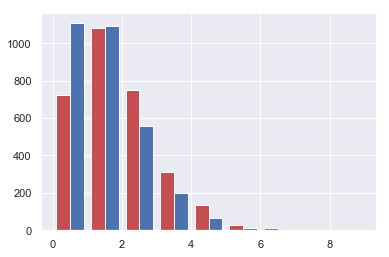

In [191]:
print table_france_home[['goals_scored', 'goals_conceded']].describe()
print plt.hist([table_france_home['goals_scored'], table_france_away['goals_scored']], color=['r','b'], bins=9)


([array([ 822.,  859., 1359.]), array([1359.,  859.,  822.])], array([0., 1., 2., 3.]), <a list of 2 Lists of Patches objects>)


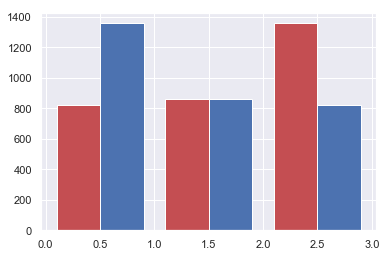

In [186]:
print plt.hist([table_france_home['points'], table_france_away['points']], color=['r','b'], bins=3)

### Research Question 2  -  What are the best and worst performing teams in France League 1 over 8 seasons?


In [205]:
# Calculate cumulative sums for the RESULTS TABLE by grouping by season and team:

table_france_results['cum_points'] = table_france_results.groupby(['season', 'team_name_stats'])['points'].cumsum()
table_france_results['won'] = table_france_results.apply(lambda x:1 if x['outcome']=='W' else 0,axis=1)
table_france_results['draw'] = table_france_results.apply(lambda x:1 if x['outcome']=='D' else 0,axis=1)
table_france_results['loss'] = table_france_results.apply(lambda x:1 if x['outcome']=='L' else 0,axis=1)
table_france_results['W'] = table_france_results.groupby(['season', 'team_name_stats'])['won'].cumsum()
table_france_results['D'] = table_france_results.groupby(['season', 'team_name_stats'])['draw'].cumsum()
table_france_results['L'] = table_france_results.groupby(['season', 'team_name_stats'])['loss'].cumsum()
table_france_results['cum_GF'] = table_france_results.groupby(['season', 'team_name_stats'])['goals_scored'].cumsum()
table_france_results['cum_GA'] = table_france_results.groupby(['season', 'team_name_stats'])['goals_conceded'].cumsum()
table_france_results['cum_GD'] = table_france_results.groupby(['season', 'team_name_stats'])['goals_diff'].cumsum()
table_france_results = table_france_results.drop(['won', 'draw', 'loss'], axis=1)
table_france_results.head()

,index,league,season,stage,date,match_api_id,home_team_api_id,home_team,away_team_api_id,away_team,home_team_goal,away_team_goal,home_player_1,home_player_2,home_player_3,home_player_4,home_player_5,home_player_6,home_player_7,home_player_8,home_player_9,home_player_10,home_player_11,away_player_1,away_player_2,away_player_3,away_player_4,away_player_5,away_player_6,away_player_7,away_player_8,away_player_9,away_player_10,away_player_11,team_name_stats,outcome,points,goals_scored,goals_conceded,goals_diff,cum_points,W,D,L,cum_GF,cum_GA,cum_GD
0,0,France Ligue 1,2008/2009,1,2008-08-09,483129,8583,AJ Auxerre,9830,FC Nantes,2,1,40714.0,11323.0,30823.0,26136.0,39996.0,30977.0,39993.0,26376.0,39999.0,26288.0,34037.0,26252.0,NaN,26279.0,26284.0,26778.0,26040.0,26261.0,27009.0,31318.0,34183.0,30753.0,AJ Auxerre,W,3,2,1,1,3,1,0,0,2,1,1
1,0,France Ligue 1,2008/2009,1,2008-08-09,483129,8583,AJ Auxerre,9830,FC Nantes,2,1,40714.0,11323.0,30823.0,26136.0,39996.0,30977.0,39993.0,26376.0,39999.0,26288.0,34037.0,26252.0,NaN,26279.0,26284.0,26778.0,26040.0,26261.0,27009.0,31318.0,34183.0,30753.0,FC Nantes,L,0,1,2,-1,0,0,0,1,1,2,-1
2,1,France Ligue 1,2008/2009,1,2008-08-09,483130,9827,Girondins de Bordeaux,7819,SM Caen,2,1,30458.0,32571.0,38703.0,40543.0,26119.0,39978.0,39962.0,33744.0,39963.0,31292.0,25537.0,11321.0,11324.0,26412.0,46338.0,11327.0,26420.0,26191.0,11329.0,18913.0,35410.0,46261.0,Girondins de Bordeaux,W,3,2,1,1,3,1,0,0,2,1,1
3,1,France Ligue 1,2008/2009,1,2008-08-09,483130,9827,Girondins de Bordeaux,7819,SM Caen,2,1,30458.0,32571.0,38703.0,40543.0,26119.0,39978.0,39962.0,33744.0,39963.0,31292.0,25537.0,11321.0,11324.0,26412.0,46338.0,11327.0,26420.0,26191.0,11329.0,18913.0,35410.0,46261.0,SM Caen,L,0,1,2,-1,0,0,0,1,1,2,-1
4,2,France Ligue 1,2008/2009,1,2008-08-09,483131,9746,Le Havre AC,9831,OGC Nice,1,0,41186.0,71607.0,38111.0,46447.0,103470.0,46651.0,46647.0,109590.0,46656.0,26405.0,41146.0,33617.0,26356.0,41121.0,26304.0,41019.0,30908.0,41122.0,26325.0,39987.0,94318.0,38108.0,Le Havre AC,W,3,1,0,1,3,1,0,0,1,0,1


In [206]:
# Calculate rank of each command (sum of points, goal difference, and goals scored):

table_france_results['rank'] = table_france_results.apply(lambda x: x['cum_points']*10000 +x['cum_GD']*50 +x['cum_GF'],axis=1)

In [207]:
# Calculate PLACE of the team in results table based on rank

table_france_results['position'] = table_france_results.groupby(['season','stage'])['rank'].rank(ascending=False, method='min').astype(int)
#table_france_results.head(20).sort_values(['position','team_name_stats'])[['season', 'position','team_name_stats','W','D','L','cum_GF','cum_GA','cum_GD','cum_points']]

In [208]:
# Creating a dataframe with data for the last stage of each season only in order to display team position
# as value on a heatmap:

is_38 = table_france_results['stage']==38
table_france_results_38 = table_france_results[is_38]
table_france_results_38.head(20).sort_values(['position','team_name_stats'])[['season', 'position','team_name_stats','W','D','L','cum_GF','cum_GA','cum_GD','cum_points']]

,season,position,team_name_stats,W,D,L,cum_GF,cum_GA,cum_GD,cum_points
741,2008/2009,1,Girondins de Bordeaux,24,8,6,64,34,30,80
748,2008/2009,2,Olympique de Marseille,22,11,5,67,35,32,77
759,2008/2009,3,Olympique Lyonnais,20,11,7,52,29,23,71
758,2008/2009,4,Toulouse FC,16,16,6,45,27,18,64
744,2008/2009,5,LOSC Lille,17,13,8,51,39,12,64
754,2008/2009,6,Paris Saint-Germain,19,7,12,49,38,11,64
749,2008/2009,7,Stade Rennais FC,15,16,7,42,34,8,61
751,2008/2009,8,AJ Auxerre,16,7,15,35,35,0,55
752,2008/2009,9,OGC Nice,13,11,14,40,41,-1,50
746,2008/2009,10,FC Lorient,10,15,13,47,47,0,45


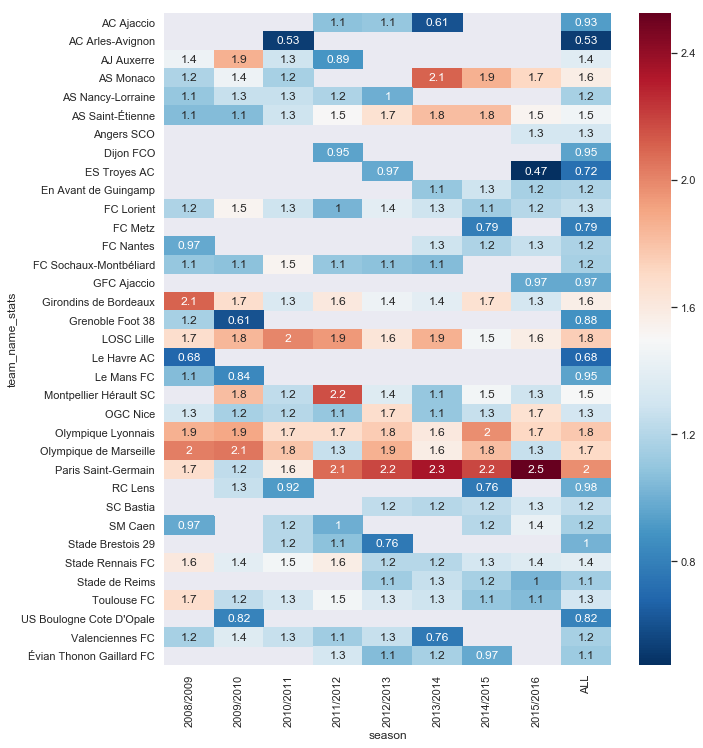

In [210]:
# Geenerating heatmap with seasons on x axis and teams on y axis. Average score per game is shown as z-value:

france_mean = table_france_results.pivot_table(index="team_name_stats", columns="season", values="points")
france_mean['ALL'] = france_mean.mean(axis=1)

z = france_mean.fillna(0).values
x = france_mean.columns.tolist()
y = france_mean.index.tolist()

sns.set(font_scale=1)
fig, ax = plt.subplots(figsize=(10,12))
heat_map = sns.heatmap(france_mean, annot=True, ax=ax, cmap='RdBu_r')

plt.show()

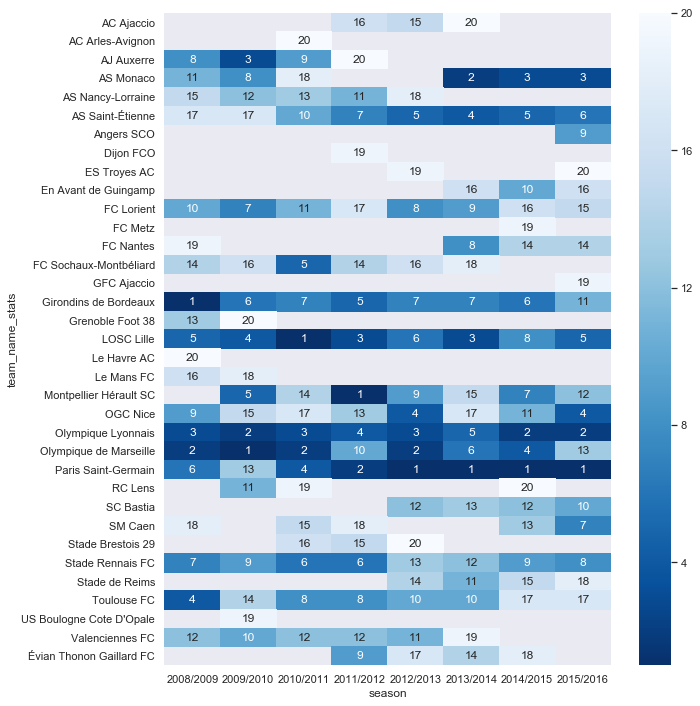

In [211]:
# Geenerating heatmap with seasons on x axis and teams on y axis. Position of the team in results table
# is shown as z-value:

france_position = table_france_results_38.pivot_table(index="team_name_stats", columns="season", values="position")
z = france_position.fillna(0).values
x = france_position.columns.tolist()
y = france_position.index.tolist()

sns.set(font_scale=1)
fig, ax = plt.subplots(figsize=(10,12))
heat_map = sns.heatmap(france_position, annot=True, ax=ax, cmap='Blues_r')

plt.show()

In [161]:
#france_mean.sort_values(['ALL'], ascending=False)

### Research Question 3  -  List the highest rated players in the League over 8 seasons

In [60]:
# Create a list of ids of all the players in France League:

tmp = table_france_results[['home_player_1', 'home_player_2', 'home_player_3', 'home_player_4', 'home_player_5',
       'home_player_6', 'home_player_7', 'home_player_8', 'home_player_9', 'home_player_10', 'home_player_11',
       'away_player_1', 'away_player_2', 'away_player_3', 'away_player_4', 'away_player_5', 'away_player_6',
       'away_player_7', 'away_player_8', 'away_player_9', 'away_player_10', 'away_player_11']]
series_france_players = pd.DataFrame({'player_api_id': tmp.values.ravel()})

In [61]:
# Clean the list of players:

series_france_players = series_france_players.dropna()
series_france_players = series_france_players.drop_duplicates(subset=None, keep='first', inplace=False)
series_france_players = series_france_players.sort_values('player_api_id')
series_france_players['player_api_id'] = series_france_players['player_api_id'].astype(int)
series_france_players = series_france_players.reset_index()
series_france_players = series_france_players.drop(['index'], axis=1)


In [67]:
# Create a dataframe with league, season, and date information:

df_france_date = table_france_results[['league', 'season', 'date']]
df_france_date = df_france_date.drop_duplicates(subset='date', keep='first', inplace=False)


In [199]:
# Merge dataframes to obtain information on players in France League:

tmp = player_stats.merge(series_france_players, on='player_api_id', how='inner')
table_france_players = tmp.merge(df_france_date, on='date', how='inner')

# Print highest rated players in the France League 1 over 8 seasons
# based on 'overall rating' data in players attributes table:

group_season_max = table_france_players.loc[table_france_players.groupby('season')['overall_rating'].idxmax()].reset_index()
print group_season_max[['season', 'player_name', 'player_api_id', 'overall_rating']]


      season         player_name  player_api_id  overall_rating
0  2008/2009  Zlatan Ibrahimovic          35724            89.0
1  2009/2010  Zlatan Ibrahimovic          35724            88.0
2  2011/2012  Zlatan Ibrahimovic          35724            88.0
3  2012/2013      Radamel Falcao          22543            90.0
4  2013/2014      Radamel Falcao          22543            90.0
5  2014/2015  Zlatan Ibrahimovic          35724            90.0
6  2015/2016         Eden Hazard         107417            89.0


<a id='conclusions'></a>
## Conclusions


- Paris Saint-Germain is leading in France League 1, with the overall average score of 1.98 points per game. The team won the League the last 4 seasons. Olympique Lyonnais is on the second place and LOSC Lille is on the third with the overall scores of 1.77 and 1.75 points per game respectively. Each of these teams won the League once.
- FC Lorient has shown the poorest performance among the teams that played all 8 seasons (score of 1.26 points per game).
- Among the 35 teams playing in the League over 8 seasons AC Arles-Avignon has the poorest score of 0.52, palaying in the League once in 2010/2011 season.  

- In general HOME teams win and score more often than AWAY teams. This conclusion is based on current data set only and not confirmed by statistical analises of any kind.
- The distributions of scored goals for HOME (red) and AWAY (blue) teams show that home teams on average win more often than away teams with the mean scored goals of 1.4 for HOME team versus 1.04 for AWAY team.
- Average points per game are 1.62 versus 1.09 for HOME and AWAY teams respectively.
- Zlatan Ibrahimovic had the highest overall rating among the players of the France League 1 over 4 seasons (2008/2009, 2009/2010, 2011/2012, and 2014/2015), following by Radamel Falcao (seasons 2012/2013 and 2013/2014) and by Eden Hazard (season 2015/2016)

<a id='acknowledgements'></a>
## Acknowledgements


- This project work was inspired by the discussion **Data Wrangling to extract match Stats** on Kaggle (https://www.kaggle.com/chinmaypai/data-wrangling-to-extract-match-stats), where the given codes, techniques, and explanations of how to use the dataset were absolutle indispensable for my understanding of data and its wrangling and analyzing.
- Numerous questions during this project were answered with the help of the website https://stackoverflow.com
- Other websites were also helpful:
 - http://seaborn.pydata.org
 - https://www.geeksforgeeks.org
 - https://jakevdp.github.io/PythonDataScienceHandbook/03.06-concat-and-append.html
 - https://pythonexamples.org/pandas-dataframe-sort-by-column/
 - https://dfrieds.com/data-analysis/pivot-table-python-pandas
 - https://www.dataquest.io/blog/tutorial-time-series-analysis-with-pandas/